In [1]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils
from const import *

### GPU Setup

In [5]:
# Specific GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0:4], 'GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
mirro_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


### Data Preprocessing

In [6]:
###      DOUBLE CHECK      ###
detec_type = 'plane_moon_cut_injec'

In [7]:
# Find the most recent file in injec_curve
datas = utils.retur_most_recen(f'{xom_data_path}padde_cuts/')
# datas = 'padde_cuts-34925-1370-8598.pkl'
print(f'File: {datas}')

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

File: padde_cuts-34925-1370-8598.pkl


In [8]:
numbe_sampl = -1

# Create a shuffled sample of the data
rando_shuff_x_data = raw_x_data[utils.retur_rando_sampl(
    numbe_sampl, len(raw_x_data))]
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1][detec_type]

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

19.15% of the dataset contains a full injection


In [9]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train_np = x_data[:split]
full_x_train = norma_full_x_data[:split]
x_test_np = x_data[split:stop]
full_x_test = norma_full_x_data[split:stop]
y_train_np = y_data[:split]
y_test_np = y_data[split:stop]

In [10]:
# Mask the data
masking = layers.Masking(mask_value=0., input_shape = (1900, 1))

x_train_unmas = tf.convert_to_tensor(x_train_np)
x_test_unmas = tf.convert_to_tensor(x_test_np)
y_train = tf.convert_to_tensor(y_train_np)
y_test = tf.convert_to_tensor(y_test_np)
x_train = masking(x_train_unmas)
x_test = masking(x_test_unmas)

In [11]:
# Remove non-full batches (because they cause problems)
batch_size = 20

x_train = x_train[:-(x_train.shape[0] % batch_size)]
y_train = y_train[:-(y_train.shape[0] % batch_size)]
x_test = x_test[:-(x_test.shape[0] % batch_size)]
y_test = y_test[:-(y_test.shape[0] % batch_size)]

### Training

In [12]:
# Callbacks

# tensorboard = TensorBoard(log_dir=f'{main_path}tensorboard/{dataset}_{int(time.time())}')
early_stopp = EarlyStopping(monitor='val_accuracy', patience=5)
resto_valid_accur = utils.resto_best_valid_accur()
callb = [resto_valid_accur, early_stopp]#, tensorboard]

#### New Model

In [13]:
# Model

l2_norma_gradi = 0.25
with mirro_strat.scope():
    model = keras.Sequential()

    model.add(
        layers.GRU(68,
                   activation='tanh',
                   input_shape=(1900, 1),
                   return_sequences=True))
    model.add(layers.GRU(48, activation='tanh'))

    model.add(layers.Dense(40, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Nadam(learning_rate=3e-4,
                                    clipnorm=l2_norma_gradi)
    
    # Metrics
    metri = ['accuracy', Precision(), Recall()]
    
    model.compile(loss='BinaryCrossentropy',
                  optimizer=opt,
                  metrics=metri)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1900, 68)          14484     
                                                                 
 gru_1 (GRU)                 (None, 48)                16992     
                                                                 
 dense (Dense)               (None, 40)                1960      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                656       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [20]:
histo = model.fit(x_train,
                  y_train,
                  epochs=5,
                  batch_size=batch_size,
                  callbacks=callb,
                  validation_data=(x_test, y_test))

Epoch 1/5
1649/1650 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.8089 - precision: 0.0000e+00 - recall: 0.0000e+00

CancelledError: Graph execution error:

Detected at node 'replica_2/assert_greater_equal/Assert/AssertGuard/Assert/data_2' defined at (most recent call last):
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/threading.py", line 930, in _bootstrap
      self._bootstrap_inner()
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/threading.py", line 973, in _bootstrap_inner
      self.run()
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/engine/training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/rfradkin/miniconda3/envs/xom/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'replica_2/assert_greater_equal/Assert/AssertGuard/Assert/data_2'
RecvAsync is cancelled.
	 [[{{node replica_2/assert_greater_equal/Assert/AssertGuard/Assert/data_2}}]] [Op:__inference_train_function_28584]

#### Continue Training

### Testing

In [12]:
# Set True if want to use the full dataset, not
# just the testing dataset
full_datas = True

# Specify start and stop if want to use a section
# of the data
start = 0
stop = None

if full_datas:
    x_full_predi_data = norma_full_x_data[start:stop]
    x_predi_data = x_data[start:stop]
    y_predi_data = y_data[start:stop]
else:
    x_full_predi_data = full_x_test[start:stop]
    x_predi_data = x_test[start:stop]
    y_predi_data = y_test_np[start:stop]

In [13]:
model_file = f'combi-padde_cuts-1255247-1644454393.pkl-0-1645790147.h5'
model = tf.keras.models.load_model(f'{xom_data_path}plane_moon_model/{model_file}');

In [14]:
# Make predictions
predi = model.predict(x_predi_data).squeeze()

In [15]:
cutof = 0.5

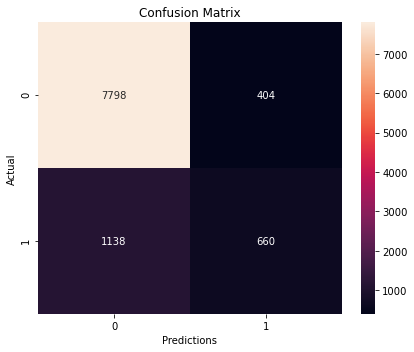

In [16]:
utils.show_confu_matri(x_full_predi_data, predi, cutof)#, 'stell_radiu', 5)

In [19]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

In [21]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

In [22]:
# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

In [ ]:
utils.show_featu_preci_recal(x_full_predi_data,
                       predi,
                       y_predi_data,
                       cutof,
                       featu='moon_radiu',
                       bins=25,
                       equal_width_bins=True,
                       stand_axis=True)
# Possible third axis with AUC
# AUC in red overplotted

In [ ]:
importlib.reload(utils)

In [ ]:
# can you have a false positive rate as a function of moon radius??

In [ ]:
utils.show_preci_recal(predi, y_predi_data, cutof)

In [ ]:
utils.show_roc(predi, y_predi_data, cutof)

In [ ]:
utils.show_histo(norma_full_x_data, 'moon_radiu')

#### Formatting